In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from functools import partial
import time
from IPython.display import clear_output
import mps
import tebd
import seaborn as sns

In [2]:
def apply_total_hamiltonian(
    state: np.ndarray, nn_hamiltonian: np.ndarray, N: int, d: int
):
    """
    Apply the total Hamiltonian to a given quantum state.
    Adapted from www.tensors.net/exact-diagonalization

    Parameters:
        state (numpy.ndarray): The quantum state to which the Hamiltonian is applied. shape(d**N)
        nn_hamiltonian (numpy.ndarray): The nearest-neighbor Hamiltonian. shape(d**2, d**2)
        N (int): The number of lattice sites in the quantum system.
        d (int): The local dimension of the Hilbert space (2 for qubits).

    Returns:
        new_state (numpy.ndarray): The resulting quantum state after applying the total Hamiltonian.
    """
    new_state = np.zeros_like(state)

    # Apply nearest neighbor hamiltonian to sites j=0 to j=N-1
    for j in range(N - 1):
        # Reshape state so that spectator qubits are conserved along axis 1
        state_with_spectators_conserved_along_ax1 = state.reshape(
            d**j, d**2, d ** (N - j - 2)
        )

        # Calculate tensor product with nearest-neighbor hamiltonian along axis 1
        new_state += (
            np.tensordot(
                nn_hamiltonian,
                state_with_spectators_conserved_along_ax1,
                axes=[[1], [1]],
            )
            .transpose(1, 0, 2)
            .reshape(d**N)
        )

    # Apply nearest-neighbor hamiltonian to site j=N with periodic boundary condition
    new_state += (
        np.tensordot(
            nn_hamiltonian.reshape(d, d, d, d),
            state.reshape(d, d ** (N - 2), d),
            axes=[[2, 3], [2, 0]],
        )
        .transpose(1, 2, 0)
        .reshape(d**N)
    )
    
    return new_state

In [3]:
d = 2  # Local dimension
sx, sy, sz = tebd.generate_spin_operators(s=(d - 1) / 2)
nn_hamiltonian = -(np.kron(sx, sx) + np.kron(sy, sy) + 0 * np.kron(sz, sz))

In [12]:
Ns = np.arange(2, 24, 2)
ed_runtimes = np.zeros_like(Ns)
for i, N in enumerate(Ns):
    print(N)
    # Cast Hamiltonian as linear operator to diagonalize
    hamiltonian_total_lo = scipy.sparse.linalg.LinearOperator(
        shape=(d**N, d**N),
        matvec=partial(apply_total_hamiltonian, nn_hamiltonian=nn_hamiltonian, N=N, d=d),
        dtype=np.cfloat,
    )
    runtimes = np.zeros(3)
    for j in range(3):
        print(j)
        start = time.process_time()
        a, b = scipy.sparse.linalg.eigsh(hamiltonian_total_lo, k=1, which='SA')
        stop = time.process_time()
        runtimes[j] = stop - start
    ed_runtimes[i] = runtimes.mean()
    clear_output()

In [15]:
tebd_runtimes = np.zeros_like(Ns)
for i, N in enumerate(Ns):
    print(N)
    runtimes = np.zeros(3)
    for j in range(3):
        print(j)
        # Initialise MPS
        mps_tensors, weights = mps.initialise_random_mps(N, d, chi=16)

        start = time.process_time()
        # Evolve state in imaginary time using TEBD
        imag_gate = scipy.linalg.expm(- 0.1 * nn_hamiltonian).reshape(d, d, d, d)
        for k in range(50):
            mps_tensors, weights = tebd.do_tebd_timesteps(10, imag_gate, mps_tensors, weights, max_chi_trunc=16)
            mps_tensors, weights = tebd.do_tebd_midstep(mps_tensors, weights, nn_hamiltonian, print_energy=False)

        rhos = mps.reduced_density_matrices(mps_tensors, weights)
        energy = ncon([nn_hamiltonian.reshape((d, d, d, d)), np.array(rhos)], [[1,2,3,4], [5,1,2,3,4]])
        stop = time.process_time()
        runtimes[j] = stop - start
    tebd_runtimes[i] = runtimes.mean()
    clear_output()

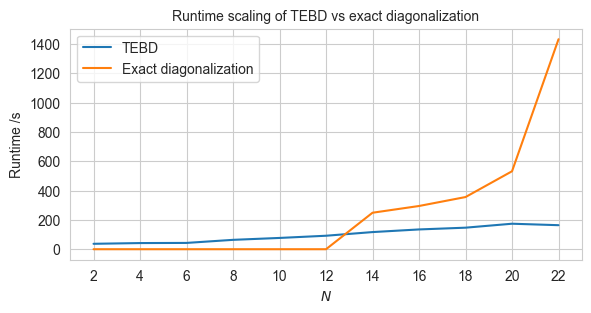

In [25]:
sns.set_style("whitegrid")
colors = sns.color_palette()

fig, ax0 = plt.subplots(figsize=(6.6, 3))
ax0.set_xticks(np.arange(0, 23, 2))
ax0.set_xlabel(r'$N$', fontsize=10)
ax0.set_ylabel(r'Runtime /s', fontsize=10)
ax0.set_title('Runtime scaling of TEBD vs exact diagonalization', fontsize=10)

ax0.plot(Ns, tebd_runtimes, label='TEBD')
ax0.plot(Ns, ed_runtimes, label='Exact diagonalization')
ax0.legend(fontsize=10)
# plt.savefig('./Report/figures/runtimes.pdf', bbox_inches='tight')